## Importing the modules

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torch.utils.data import random_split

import cv2
import PIL

## Preparing the data

In [2]:
## initialization
IMG_SHAPE = (256,256)
VAL_DATASET_SIZE = 0.1 
BATCH_SIZE = 256
DATASET_SIZE = 0.1

In [3]:
DATA_DIR = "../input/food41/images"

transform_ds = T.Compose([
    T.Resize(IMG_SHAPE),
    T.RandomHorizontalFlip(),
    T.ColorJitter(hue=.05, saturation=.05),
    T.RandomRotation(20, resample=PIL.Image.BILINEAR),
    T.ToTensor()
])

ds = torchvision.datasets.ImageFolder(
    root=DATA_DIR,
    transform=transform_ds

)

print("total images = ", len(ds))

total images =  101000


In [4]:
ds

Dataset ImageFolder
    Number of datapoints: 101000
    Root location: ../input/food41/images
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=None, contrast=None, saturation=[0.95, 1.05], hue=[-0.05, 0.05])
               RandomRotation(degrees=(-20, 20), resample=2, expand=False)
               ToTensor()
           )

In [5]:
val_ds_size = int(len(ds) * VAL_DATASET_SIZE)
train_ds_size = len(ds) - val_ds_size

train_ds, val_ds = random_split(ds, [train_ds_size, val_ds_size])

In [6]:
train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, BATCH_SIZE, num_workers=4, pin_memory=True)

In [7]:
def show_images(train_dl):
    for images, labels in train_dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=8).permute(1,2,0))
        break

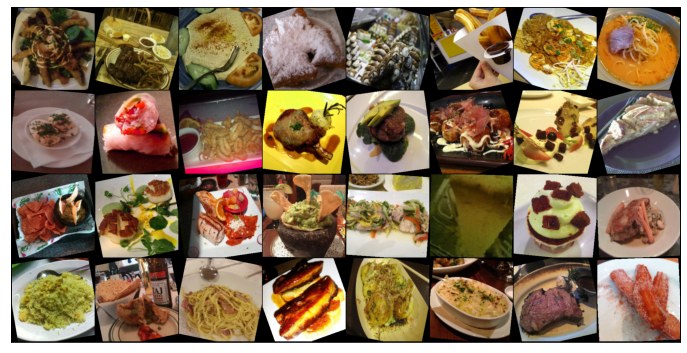

In [8]:
show_images(train_dl)

## Moving the data to the GPU

In [9]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)
            
    def __len__(self):
        return len(self.dl)

In [10]:
device = get_device()
device

device(type='cuda')

In [11]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## Defining the Model

In [12]:
def accuracy(out, labels):
    _, preds = torch.max(out, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [13]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {"val_loss": loss.detach(), "val_acc": acc}
    
    def validation_epoch_end(self, outputs):
        batch_loss = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}
    
    def epoch_end(self, epoch, epochs, result):
        print("Epoch: [{}/{}], last_lr: {:.6f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, epochs, result["lrs"][-1], result["train_loss"], result["val_loss"], result["val_acc"]))

In [14]:
network = models.resnet18(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [15]:
network.fc

Linear(in_features=512, out_features=1000, bias=True)

In [16]:
network.fc.in_features

512

In [17]:
network.classifier[6].in_features

AttributeError: 'ResNet' object has no attribute 'classifier'

In [18]:
class resnet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet18(pretrained=True)
        number_of_features =  self.network.fc.in_features
        self.network.fc = nn.Linear(number_of_features, 101)
        
    def forward(self, xb):
        return self.network(xb)
        
    def freeze(self):
        for param in self.network.parameters():
            param.requires_grad=False
        for param in self.network.classifier[6].parameters():
            param.requires_grad=True
        
    def unfreeze(self):
        for param in self.network.parameters():
            param.requires_grad=True

In [19]:
model = to_device(resnet(), device)

## Training

In [20]:
@torch.no_grad()
def evaluate(model, val_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_dl]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]
    
def fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, weight_decay=0, grad_clip=None,
                 opt_func=torch.optim.Adam):
    
    torch.cuda.empty_cache()
    
    history = []
    opt = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr, epochs=epochs,
                                                   steps_per_epoch=len(train_dl))
    
    for epoch in range(epochs):
        model.train()
        train_loss = []
        lrs = []
        for batch in tqdm(train_dl):
            loss = model.training_step(batch)
            train_loss.append(loss)
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            opt.step()
            opt.zero_grad()
            
            lrs.append(get_lr(opt))
            sched.step()
            
        result = evaluate(model, val_dl)
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch, epochs, result)
        history.append(result)
    return history
    

In [21]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 4.838178634643555, 'val_acc': 0.006640625186264515}]

In [22]:
# model.freeze()

In [23]:
model.unfreeze()

In [24]:
epochs = 5
max_lr = 10e-5
grad_clip = 0.1
weight_decay = 10e-4
opt_func=torch.optim.Adam

In [25]:
%%time

history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, weight_decay=weight_decay,
                        grad_clip=grad_clip, opt_func=opt_func)


Epoch: [0/5], last_lr: 0.000076, train_loss: 3.7934, val_loss: 2.2662, val_acc: 0.5211



Epoch: [1/5], last_lr: 0.000095, train_loss: 1.6521, val_loss: 1.3780, val_acc: 0.6671



Epoch: [2/5], last_lr: 0.000061, train_loss: 1.1189, val_loss: 1.1144, val_acc: 0.7132



Epoch: [3/5], last_lr: 0.000019, train_loss: 0.8897, val_loss: 0.9889, val_acc: 0.7462



Epoch: [4/5], last_lr: 0.000000, train_loss: 0.7799, val_loss: 0.9575, val_acc: 0.7575
CPU times: user 4min 15s, sys: 3min 8s, total: 7min 23s
Wall time: 1h 44min 54s


In [26]:
model.unfreeze()

In [27]:
%%time

history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, weight_decay=weight_decay,
                        grad_clip=grad_clip, opt_func=opt_func)


Epoch: [0/5], last_lr: 0.000076, train_loss: 0.7722, val_loss: 1.0224, val_acc: 0.7380



Epoch: [1/5], last_lr: 0.000095, train_loss: 0.7967, val_loss: 1.1021, val_acc: 0.7124



Epoch: [2/5], last_lr: 0.000061, train_loss: 0.6761, val_loss: 0.9327, val_acc: 0.7543



Epoch: [3/5], last_lr: 0.000019, train_loss: 0.5350, val_loss: 0.8521, val_acc: 0.7790



Epoch: [4/5], last_lr: 0.000000, train_loss: 0.4399, val_loss: 0.8383, val_acc: 0.7805
CPU times: user 4min 29s, sys: 3min 24s, total: 7min 53s
Wall time: 1h 45min 19s


## Performance

Text(0, 0.5, 'Accuracy')

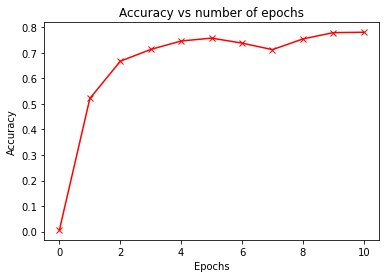

In [28]:
accuracy = [x["val_acc"] for x in history]
plt.plot(accuracy, "-rx")
plt.title("Accuracy vs number of epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0.5, 0, 'Epochs')

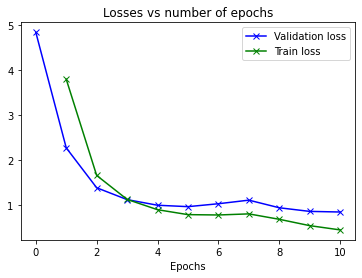

In [29]:
val_loss = [x["val_loss"] for x in history]
train_loss = [x.get("train_loss") for x in history]
plt.plot(val_loss, "-bx")
plt.plot(train_loss, "-gx")
plt.title("Losses vs number of epochs")
plt.legend(["Validation loss", "Train loss"])
plt.xlabel("Epochs")